In [1]:
from pearlsim.results_processing import *
from pearlsim.ml_utilities import extract_from_bumat
from pearlsim.material import Material
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import os
import json
import time
from numpy.random import poisson

In [2]:
working_directory = "gFHR_equilibrium"
simulation_name = "gFHR_equilibrium_<iteration>.serpent"
parameters_to_extract = ["ANA_KEFF"]
num_steps = 3
num_substeps = 3
dep_step = 6.525
decay_days = 1.0
PEBBLE_FUEL_VOLUME = 0.36263376
gamma_processing = "Serpent"
detector_response_matrix_path = "detector_data/detector_response_mat.npy"
detector_energy_grid_path = "detector_data/detector_e_grid.npy"
decay_template_path = "decay_step1_template.serpent"
gamma_template_path = "decay_step2_template.serpent"


In [3]:
detector_matrix = np.load(detector_response_matrix_path)
detector_energy_grid = np.load(detector_energy_grid_path)

In [4]:
# FIER tools

z_map = {'Ac': 89, 'Ag': 47, 'Al': 13, 'Am': 95, 'Ar': 18, 'As': 33, 'At': 85, 'Au': 79, 'B': 5, 'Ba': 56, 'Be': 4,
         'Bh': 107, 'Bi': 83, 'Bk': 97, 'Br': 35, 'C': 6, 'Ca': 20, 'Cd': 48, 'Ce': 58,
         'Cf': 98, 'Cl': 17, 'Cm': 96, 'Co': 27, 'Cr': 24, 'Cs': 55, 'Cu': 29, 'Ds': 110, 'Db': 105, 'Dy': 66, 'Er': 68,
         'Es': 99, 'Eu': 63, 'F': 9, 'Fe': 26, 'Fm': 100, 'Fr': 87, 'Ga': 31, 'Gd':
             64, 'Ge': 32, 'H': 1, 'He': 2, 'Hf': 72, 'Hg': 80, 'Ho': 67, 'Hs': 108, 'I': 53, 'In': 49, 'Ir': 77,
         'K': 19, 'Kr': 36, 'La': 57, 'Li': 3, 'Lr': 103, 'Lu': 71, 'Md': 101, 'Mg': 12, 'Mn':
             25, 'Mo': 42, 'Mt': 109, 'N': 7, 'Na': 11, 'Nb': 41, 'Nd': 60, 'Ne': 10, 'Ni': 28, 'No': 102, 'Np': 93,
         'O': 8, 'Os': 76, 'P': 15, 'Pa': 91, 'Pb': 82, 'Pd': 46, 'Pm': 61, 'Po': 84, 'Pr':
             59, 'Pt': 78, 'Pu': 94, 'Ra': 88, 'Rb': 37, 'Re': 75, 'Rf': 104, 'Rg': 111, 'Rh': 45, 'Rn': 86, 'Ru': 44,
         'S': 16, 'Sb': 51, 'Sc': 21, 'Se': 34, 'Sg': 106, 'Si': 14, 'Sm': 62, 'Sn': 50,
         'Sr': 38, 'Ta': 73, 'Tb': 65, 'Tc': 43, 'Te': 52, 'Th': 90, 'Ti': 22, 'Tl': 81, 'Tm': 69, 'U': 92, 'V': 23,
         'W': 74, 'Xe': 54, 'Y': 39, 'Yb': 70, 'Zn': 30, 'Zr': 40}

def create_fier_labels(df_columns, z_map=z_map):
    fier_labels = []
    for col in df_columns:
        if "<lib>" in col:
            col = col.replace("<lib>","0")
        fier_labels += [f"{col[:-4]},{int(col[-4:-1])},{col[-1]},"]
    return fier_labels

def gen_FIER_input(dataframe_row, output_dir_name, num_days):
    dataframe_row.columns = create_fier_labels(dataframe_row.columns)
    
    try:
        os.mkdir(f"output/{output_dir_name}")
    except:
        pass
    start_times_sec = num_days*86400
    end_times_sec = start_times_sec+1
    
    with open(f"{output_dir_name}_input.txt", "w") as f:
        f.write('MODE:SINGLE\n')
        f.write('ON DECAY PREDICTION\n')
        f.write('input_data/isotopes.csv     ISOTOPES FILE\n')
        f.write('input_data/decays.csv       DECAYS   FILE\n')
        f.write('input_data/gammas.csv       GAMMAS   FILE\n')
        f.write('YIELDS:ER\n')
        f.write('U,235,fission   	YIELDS   FILE\n')
        f.write(f'output/{output_dir_name}/decay_chains.csv 		CHAINS	OUTPUT\n')
        f.write(f'output/{output_dir_name}/decay_stems.csv 		STEMS OUTPUT\n')
        f.write(f'output/{output_dir_name}/populations.csv   		POPS	OUTPUT\n')
        f.write(f'output/{output_dir_name}/gamma_output.csv                  GAMMAS OUTPUT\n')
        f.write(f'output/{output_dir_name}/err_log.txt  		ERROR	LOG\n')
        f.write('INITIALIZE\n')
        for (column_name, column_data) in dataframe_row.iteritems():
            concentration = np.format_float_scientific(column_data.values[0], precision=10)
            f.write(f"{column_name}{concentration}\n")
        f.write("IRRADIATION\n")
        f.write("0.0,0.0\n")
        f.write("1.0,0.0\n")
        f.write("POPULATIONS\n")
        f.write("0.0\n")
        f.write(f"{np.format_float_scientific(start_times_sec)}\n")
        f.write("COUNTS\n")
        f.write(f"{np.format_float_scientific(start_times_sec)},{np.format_float_scientific(end_times_sec)}\n")
        f.write("END")
    return f"{output_dir_name}_input.txt"

def read_gammas(file_name, plot=True):
    with open(file_name, "r") as f:
        Z = np.array(f.readline().split(",")[2:])
        A = np.array(f.readline().split(",")[2:])
        I = f.readline().split(",")[2:]
        half_life = f.readline().split(",")[2:]
        energy_level = f.readline().split(",")[2:]
        gamma_energy = np.array(f.readline().split(",")[2:])
        gamma_labels = np.core.defchararray.add(Z, "-")
        gamma_labels = np.core.defchararray.add(gamma_labels,A)
        gamma_labels = np.core.defchararray.add(gamma_labels,"-")
        gamma_labels = np.core.defchararray.add(gamma_labels, gamma_energy)
        gamma_labels = np.core.defchararray.add(gamma_labels, "keV")
        gamma_energy = gamma_energy.astype("float32")
        time_vals = []
        count_matrix = []
        for line in f:
            line = line.split(',')
            time_vals += [float(line[0])]
            count_matrix += [line[2:]]
        time = np.array(time_vals)
        count_matrix = np.array(count_matrix).astype("float32")
    for i in range(len(time)):
        time = int(time_vals[i]/86400)
        counts = count_matrix[i,:]
        if plot:
            plt.figure()
            plt.vlines(gamma_energy, 0, counts)
            plt.xlim(0,7000)
            plt.ylim(1,1e13)
            plt.yscale("log")
            plt.xlabel("Energy (keV)")
            plt.ylabel("Counts")
            plt.title(f"Discrete gamma rays at t = {time}d")
            plt.show()
    count_df = pd.DataFrame(count_matrix, columns=gamma_labels)
    return count_df, time_vals


def create_spectra_with_FIER(conc_df, energy_grid, decay_days, debug = 1, delete_inputs = True):
    binned_gamma_spectra = [None]*len(conc_df)
    gamma_energies = []
    for i in range(len(conc_df)):
        start_time = time.time()
        gen_FIER_input(conc_df.iloc[[i]], f"pebble_{i}", decay_days)
        os.system(f"./fier.exe pebble_{i}_input.txt")
        count_df, time_vals = read_gammas(f"output/pebble_{i}/gamma_output.csv", False)
        
        # Create list of gamma energies that get outputted from FIER
        # Only do it once, since its the same for all of them.
        if i == 0:
            for gamma_ID in count_df.columns.str.split("-"):
                energy = float(re.findall(r'\d+', gamma_ID[2])[0])/1000
                gamma_energies += [energy]

        binned_spectrum = np.zeros_like(energy_grid-1)
        gamma_counts = np.asarray(count_df)
        for g in range(len(gamma_counts)):
            energy = gamma_energies[g]
            activity = gamma_counts[g]
            if activity > 0:
                binned_spectrum[np.searchsorted(energy_grid, energy)] += activity
        binned_gamma_spectra[i] = binned_spectrum
        elapsed_time = round(time.time() - start_time,3)
        if debug > 0:
            print(f"Pebble {i+1} finished in {elapsed_time}s")
    return binned_gamma_spectra


In [ ]:
def create_spectra_with_serpent(conc_df, decay_template_path, gamma_template_path, 
                                energy_grid, decay_days, num_cores, iteration,
                                debug = 1, delete_inputs = True):
    # Create a set of materials and dummy-geometry spheres to insert into 
    # Serpent template
    start_time = time.time()
    current_radius = 100.5
    decay_s = ""
    surfaces_s = ""
    for i in range(len(conc_df)):
        material_s = Material(f"decay{i}", conc_df.iloc[i].to_dict()).write_input(1, {}, 1, 
                                                                                  volume=PEBBLE_FUEL_VOLUME, never_burn=False)
        material_s += f"\nsurf decay{i}s sph {current_radius} 0 0 1.0 %\n"
        material_s += f"cell decay{i}c 0 decay{i} -decay{i}s%\n\n"
        decay_s += material_s
        surfaces_s += f" decay{i}s"
        current_radius += 1
    
    with open(decay_template_path, 'r') as f:
        decay1_input_s = f.read()

    decay1_input_s = decay1_input_s.replace("<total_length>",str(current_radius+0.5))
    decay1_input_s = decay1_input_s.replace("<all_surfaces>",surfaces_s)
    decay1_input_s += "\n%%% Decay Input Definitions %%%\n\n"
    decay1_input_s += decay_s
    
    decay1_file_name = f"decay_{iteration}_step1.serpent"
    with open(decay1_file_name, 'w') as f:
        f.write(decay1_input_s)
    os.system(f"sss2_2_0 {decay1_file_name} -omp {num_cores}")
    post_decay_concentrations = extract_from_bumat(decay1_file_name+".bumat1")
    conc_df = pd.DataFrame(post_decay_concentrations).fillna(0)

    
    current_radius = 100.5
    decay_s = ""
    surfaces_s = ""
    for i in range(len(conc_df)):
        material_s = Material(f"decay{i}", conc_df.iloc[i].to_dict()).write_input(1, {}, 1, 
                                                                                  volume=PEBBLE_FUEL_VOLUME, never_burn=True)
        material_s += f"\nsurf decay{i}s sph {current_radius} 0 0 1.0 %\n"
        material_s += f"cell decay{i}c 0 decay{i} -decay{i}s%\n\n"
        decay_s += material_s
        surfaces_s += f" decay{i}s"
        current_radius += 1
    with open(gamma_template_path, 'r') as f:
        decay2_input_s = f.read()
    

    decay2_input_s = decay2_input_s.replace("<total_length>",str(current_radius+0.5))
    decay2_input_s = decay2_input_s.replace("<all_surfaces>",surfaces_s)
    decay2_input_s += f"ene detector_grid 1 {np.array2string(energy_grid,threshold=10000,precision=8)[1:-1]}\n"
    decay2_input_s += f"set dspec detector_grid detector_grid"
    decay2_input_s += "\n%%% Decay Input Definitions %%%\n\n"
    decay2_input_s += decay_s
    
    decay2_file_name = f"decay_{iteration}_step2.serpent"
    with open(decay2_file_name, 'w') as f:
        f.write(decay2_input_s)
    os.system(f"sss2_2_0 {decay2_file_name} -omp {num_cores}")
    
    gspec_result_file = f"decay_{iteration}_step2.serpent_gsrc.m"
    gamma_spectrum = read_gspec(gspec_result_file, detector_energy_grid)
    spectrum_results = read_gspec(gspec_result_file, energy_grid)
    if delete_inputs:
        os.system(f"rm {decay1_input_s}*")
        os.system(f"rm {decay2_input_s}*")
    return spectrum_results
    

In [6]:

def read_core_flux(file_name, normalize_and_label=False):
    reading=False
    core_flux = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.replace("DET","")
            if "map" in line:
                reading = True
                data_array = []
                unc_array = []
            elif "]" in line and reading:
                core_flux = data_array
                avg_uncertainty = np.mean(np.array(unc_array))
                break
            elif reading:
                data = float(line.split()[10])
                unc = float(line.split()[11])
                data_array += [data]
                unc_array += [unc]
    if normalize_and_label:
        core_flux_headers = []
        num_radius_bins = len(RADIUS_BINS)-1
        num_height_bins = len(HEIGHT_BINS)-1
        num_energy_bins = len(ENERGY_BINS)-1
        bin_e = 0
        bin_r = -1
        bin_z = 0
        for i in range(len(core_flux)):
            if bin_r == num_radius_bins-1:
                bin_r = 0
                if bin_z == num_height_bins-1:
                    bin_z = 0
                    bin_e += 1
                else:
                    bin_z += 1
            else:
                bin_r += 1
            # Calculate volume of a washer, noting that height bins are in descending
            # order while radius bins are increasing
            volume = np.pi*(RADIUS_BINS[bin_r+1]**2-RADIUS_BINS[bin_r]**2)*(HEIGHT_BINS[bin_z]-HEIGHT_BINS[bin_z+1])
            energy_width = ENERGY_BINS[bin_e+1]-ENERGY_BINS[bin_e]
            core_flux[i] = core_flux[i]/volume/energy_width
            core_flux_headers += [f"binR{bin_r+1}Z{bin_z+1}E{bin_e+1}"]
    else:
        core_flux_headers = ["bin" + str(n) for n in range(1, 1 + len(core_flux))]
    core_flux = pd.DataFrame([core_flux], columns=core_flux_headers)
    return core_flux, avg_uncertainty


def read_res_file(file_name, parameter, burnup_step=2, sub_index=0):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        matches = 0
        matching_lines = []
        for i in range(len(lines)):
            if parameter in lines[i]:
                matches += 1
                if matches == burnup_step:
                    result = lines[i]
                    break
    # Sample : "ANA_KEFF                  (idx, [1:   6]) = [  1.29640E+00 0.00153  1.28804E+00 0.00150  8.70269E-03 0.02988 ];"
    result = result.split("=")[1]
    # Sample : " [  1.29640E+00 0.00153  1.28804E+00 0.00150  8.70269E-03 0.02988 ];"
    value = float(result.split()[1+sub_index*2])
    unc = float(result.split()[2+sub_index*2])
    return value, unc
        
        
def read_gspec(file_name, energy_spectrum):
    results = {}
    num_energies = len(energy_spectrum)-1
    with open(file_name, 'r') as f:
        reading = False
        for line in f:
            if "];" in line:
                reading = False
            if reading:
                line = line.split()
                value_array[i] = float(line[0])
                i += 1
            if "gspec =" in line:
                reading = True
                key = line.split("_")[1]
                i = 0
                value_array = [0]*num_energies
                results[key] = value_array
    return results

In [24]:
simulation_data = {}
total_days = 0
for i in range(1,1+num_steps):
    total_days += dep_step
    serp_file = simulation_name.replace("<iteration>", str(i))
    res_file_name = f"{working_directory}/{serp_file}_res.m"
    step_results = {}
    for parameter in parameters_to_extract:
        value, unc = read_res_file(res_file_name, parameter)
        step_results[parameter] = value
    det_file_name = f"{working_directory}/{serp_file}_det0.m"
    core_flux, core_flux_unc = read_core_flux(det_file_name, normalize_and_label=True)
    discharge_file_names = []
    discard_file_names = []
    for sub_step in range(1,1+num_substeps):
        discharge_file_name = f"discharge_pebbles_{i}_{sub_step}.json"
        discharge_file_names += [discharge_file_name]
        discard_file_name = f"discard_pebbles_{i}_{sub_step}.json"
        discard_file_names += [discard_file_name]
    simulation_data[str(i)] = {"total_days": total_days,
                     "results": step_results,
                     "core_flux": core_flux.iloc[0].to_dict(),
                     "discharge_files": discharge_file_names,
                     "energy_grid": detector_energy_grid.tolist(),
                     "operating_parameters": 
                          {
                              "power": 280e6,
                              "graphite_fraction": 0.43,
                              "threshold": 8 # passes
                          },
                     "discard_files": discard_file_names}

# FIER Setup Block
Ensure that FIER is ready to run if it is your choice of gamma processor

In [8]:
if gamma_processing == "FIER":
    
    # Download and compile FIER if not already done
    if not os.path.isdir("FIER"):
        os.system("git clone https://github.com/efmatthews/FIER.git")
        os.chdir("FIER/FIER")
        os.mkdir("output")
        os.system(f"g++ -std=c++11 *.cpp -o fier.exe")
    else:
        os.chdir("FIER/FIER")
os.chdir("../..")

In [9]:
os.chdir("/global/scratch/users/ikolaja/PEARLSim")
for sim_key in simulation_data.keys():
        discharge_files = simulation_data[sim_key]["discharge_files"]
        for sub_step in range(num_substeps):
            file = discharge_files[sub_step]
            with open(f"{working_directory}/{file}", 'r') as f:
                pebble_data = json.load(f)
        

            for pebble_ind in pebble_data.keys():
                if pebble_ind == '0':
                    conc_dict = {}
                    for iso_key in pebble_data['0']['concentration'].keys():
                        conc_dict[iso_key] = []
                for iso_key in pebble_data[pebble_ind]['concentration'].keys():
                    conc_dict[iso_key] += [pebble_data[pebble_ind]['concentration'][iso_key]]
            conc_df = pd.DataFrame(conc_dict)
            if gamma_processing == "FIER":
                os.chdir("FIER/FIER")
                create_spectra_with_FIER(conc_df, detector_energy_grid, decay_days, delete_inputs = True)
            if gamma_processing == "Serpent":
                os.chdir(working_directory)
                emitted_spectra = create_spectra_with_serpent(conc_df, "../"+decay_template_path, "../"+gamma_template_path, 
                                detector_energy_grid, decay_days, 24, f"{sim_key}_{sub_step+1}")
                os.chdir("..")
            for pebble_ind in pebble_data.keys():
                try:
                    pebble_data[pebble_ind].pop("concentration")
                except:
                    pass 
                #pebble_data[pebble_ind][f'emitted_spectrum_{round(decay_days,1)}d'] = emitted_spectra['decay'+pebble_ind]
                emitted_spectrum = emitted_spectra['decay'+pebble_ind]
                sampled_spectrum = poisson(emitted_spectrum) #(pebble_data[pebble_ind][f'emitted_spectrum_{decay_days}d'])
                detected_spectrum = poisson(detector_matrix @ sampled_spectrum).astype(float)
                pebble_data[pebble_ind][f'detected_spectrum_{round(decay_days,1)}d'] = getattr(detected_spectrum, "tolist", lambda: detected_spectrum)()
            with open(f"{working_directory}/discharge_pebbles_{sim_key}_{sub_step+1}_processed.json", 'w') as file:
                json.dump(pebble_data, file, indent=2)

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_1_step1.serpe

Nuclide  44098.09c -- ruthenium 98 at 959K (Ru-98)
Nuclide  44099.09c -- ruthenium 99 at 959K (Ru-99)
Nuclide  44100.09c -- ruthenium 100 at 959K (Ru-100)
Nuclide  44101.09c -- ruthenium 101 at 959K (Ru-101)
Nuclide  44102.09c -- ruthenium 102 at 959K (Ru-102)
Nuclide  44103.09c -- ruthenium 103 at 959K (Ru-103)
Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide

Nuclide  58143.09c -- cerium 143 at 959K (Ce-143)
Nuclide  58144.09c -- cerium 144 at 959K (Ce-144)
Nuclide     581450 -- cerium 145 at 959K (Ce-145)
Nuclide     581460 -- cerium 146 at 959K (Ce-146)
Nuclide     581470 -- cerium 147 at 959K (Ce-147)
Nuclide  59141.09c -- praseodymium 141 at 959K (Pr-141)
Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c --

Adding nuclides in material decay214...

Adding nuclides in material decay215...

Adding nuclides in material decay216...

Adding nuclides in material decay217...

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides 

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides in material decay432...

Adding nuclides in material decay433...

Adding nuclides in material decay434...

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding remaining data and forming paths...

Nuclide      10030 -- tritium at 959K (H-3)
Nuclide      20030 -- helium 3 at 959K (He-3)
Nuclide     561310 -- barium 131 at 959K (Ba-131)
Nuclide     561300 -- barium 130 at 959K (Ba-130)
Nuclide     571360 -- lanthanum 136 at 959K (La-136)
Nuclide     581360 -- cerium 136 at 959K (Ce-136)
Nuclide     601410 -- neodymium 141 at 959K (Nd-141)
Nuclide     591390 -- praseodymium 139 at 959K (Pr-139)
Nuclide     601400 -- neodymium 140 at 959K (Nd-140)
Nuclide     621450 -- samarium 145 at 959K (Sm-145)
Nuclide     561331 -- barium 133m at 95

Nuclide  34074.09c -- selenium 74 at 959K (Se-74)
Nuclide     340730 -- selenium 73 at 959K (Se-73)
Nuclide     330730 -- arsenic 73 at 959K (As-73)
Nuclide     340750 -- selenium 75 at 959K (Se-75)
Nuclide     330751 -- arsenic 75m at 959K (As-75m)
Nuclide     330720 -- arsenic 72 at 959K (As-72)
Nuclide     320710 -- germanium 71 at 959K (Ge-71)
Nuclide     330760 -- arsenic 76 at 959K (As-76)
Nuclide     330821 -- arsenic 82m at 959K (As-82m)
Nuclide     330900 -- arsenic 90 at 959K (As-90)
Nuclide     340900 -- selenium 90 at 959K (Se-90)
Nuclide     350900 -- bromine 90 at 959K (Br-90)
Nuclide     360900 -- krypton 90 at 959K (Kr-90)
Nuclide     330910 -- arsenic 91 at 959K (As-91)
Nuclide     340910 -- selenium 91 at 959K (Se-91)
Nuclide     350910 -- bromine 91 at 959K (Br-91)
Nuclide     360910 -- krypton 91 at 959K (Kr-91)
Nuclide     370910 -- rubidium 91 at 959K (Rb-91)
Nuclide     330920 -- arsenic 92 at 959K (As-92)
Nuclide     340920 -- selenium 92 at 959K (Se-92)
Nuclide

Nuclide  51124.09c -- antimony 124 at 959K (Sb-124)
Nuclide     511241 -- antimony 124m at 959K (Sb-124m)
Nuclide     511262 -- antimony 126m at 959K (Sb-126m)
Nuclide     511281 -- antimony 128m at 959K (Sb-128m)
Nuclide     511321 -- antimony 132m at 959K (Sb-132m)
Nuclide     511341 -- antimony 134m at 959K (Sb-134m)
Nuclide     511380 -- antimony 138 at 959K (Sb-138)
Nuclide     521380 -- tellurium 138 at 959K (Te-138)
Nuclide     531380 -- iodine 138 at 959K (I-138)
Nuclide     511390 -- antimony 139 at 959K (Sb-139)
Nuclide     521390 -- tellurium 139 at 959K (Te-139)
Nuclide     531390 -- iodine 139 at 959K (I-139)
Nuclide     521231 -- tellurium 123m at 959K (Te-123m)
Nuclide     521400 -- tellurium 140 at 959K (Te-140)
Nuclide     531400 -- iodine 140 at 959K (I-140)
Nuclide     541400 -- xenon 140 at 959K (Xe-140)
Nuclide     521410 -- tellurium 141 at 959K (Te-141)
Nuclide     531410 -- iodine 141 at 959K (I-141)
Nuclide     541410 -- xenon 141 at 959K (Xe-141)
Nuclide     5

Nuclide  63154.09c -- europium 154 at 959K (Eu-154)
Nuclide     641540 -- gadolinium 154 at 959K (Gd-154)
Nuclide     631660 -- europium 166 at 959K (Eu-166)
Nuclide     641660 -- gadolinium 166 at 959K (Gd-166)
Nuclide     651660 -- terbium 166 at 959K (Tb-166)
Nuclide     661660 -- dysprosium 166 at 959K (Dy-166)
Nuclide     671660 -- holmium 166 at 959K (Ho-166)
Nuclide     681660 -- erbium 166 at 959K (Er-166)
Nuclide     631670 -- europium 167 at 959K (Eu-167)
Nuclide     641670 -- gadolinium 167 at 959K (Gd-167)
Nuclide     651670 -- terbium 167 at 959K (Tb-167)
Nuclide     661670 -- dysprosium 167 at 959K (Dy-167)
Nuclide     671670 -- holmium 167 at 959K (Ho-167)
Nuclide     681670 -- erbium 167 at 959K (Er-167)
Nuclide     681671 -- erbium 167m at 959K (Er-167m)
Nuclide     641680 -- gadolinium 168 at 959K (Gd-168)
Nuclide     651680 -- terbium 168 at 959K (Tb-168)
Nuclide     661680 -- dysprosium 168 at 959K (Dy-168)
Nuclide     671680 -- holmium 168 at 959K (Ho-168)
Nuclide 

Adjusting nuclide  41094.09c temperature from 900K to 959K...
Adjusting nuclide  41095.09c temperature from 900K to 959K...
Adjusting nuclide  42094.09c temperature from 900K to 959K...
Adjusting nuclide  42095.09c temperature from 900K to 959K...
Adjusting nuclide  42096.09c temperature from 900K to 959K...
Adjusting nuclide  42097.09c temperature from 900K to 959K...
Adjusting nuclide  42098.09c temperature from 900K to 959K...
Adjusting nuclide  42099.09c temperature from 900K to 959K...
Adjusting nuclide  42100.09c temperature from 900K to 959K...
Adjusting nuclide  43099.09c temperature from 900K to 959K...
Adjusting nuclide  44098.09c temperature from 900K to 959K...
Adjusting nuclide  44099.09c temperature from 900K to 959K...
Adjusting nuclide  44100.09c temperature from 900K to 959K...
Adjusting nuclide  44101.09c temperature from 900K to 959K...
Adjusting nuclide  44102.09c temperature from 900K to 959K...
Adjusting nuclide  44103.09c temperature from 900K to 959K...
Adjustin

Writing depletion output...
OK.


Simulation completed.
------------------------------------------------------------
Wed Oct 11 19:21:19 2023  (errors: 0, warnings: 9, notes: 0)



sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_1_step2.serpe

Adding nuclides in material decay8...

Adding nuclides in material decay9...

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...


Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding nuclides in material decay18...

Adding nuclides in material decay19...

Adding nuclides in material decay20...

Adding nuclides in material decay21...

Adding nuclides in material decay22...

Adding nuclides in material decay23...

Adding nuclides in material decay24...

Adding nuclides in material decay25...

Adding nuclides in material decay26...

Adding nuclides in material decay27...

Adding nuclides in material decay28...

Adding nuclides in material decay29...

Adding nuclides in material decay30...

Adding nuclides in material decay31...

Adding nuclides in material decay32...

A

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides in material decay272...

Adding nuclides in material decay273...

Adding nuclides in material decay274...

Adding nuclides in material decay275...

Adding nuclides in material decay276...

Adding nuclides in material decay277...

Adding nuclides 

Adjusting nuclide  58138.09c temperature from 900K to 959K...
Adjusting nuclide  58139.09c temperature from 900K to 959K...
Adjusting nuclide  58140.09c temperature from 900K to 959K...
Adjusting nuclide  58141.09c temperature from 900K to 959K...
Adjusting nuclide  58142.09c temperature from 900K to 959K...
Adjusting nuclide  58143.09c temperature from 900K to 959K...
Adjusting nuclide  58144.09c temperature from 900K to 959K...
Adjusting nuclide  59141.09c temperature from 900K to 959K...
Adjusting nuclide  59142.09c temperature from 900K to 959K...
Adjusting nuclide  59143.09c temperature from 900K to 959K...
Adjusting nuclide  60142.09c temperature from 900K to 959K...
Adjusting nuclide  60143.09c temperature from 900K to 959K...
Adjusting nuclide  60144.09c temperature from 900K to 959K...
Adjusting nuclide  60145.09c temperature from 900K to 959K...
Adjusting nuclide  60146.09c temperature from 900K to 959K...
Adjusting nuclide  60147.09c temperature from 900K to 959K...
Adjustin

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon library)
Element  45000.84p -- rhodium (photon library)
Element  46000.84p -- palladium (photon library)
Element  47000.84p -- silver (photon libra

------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_1_step2.serpent" 

Source batch 108 / 200 (5 histories per batch)

Running time :                  0:00:37
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  1999.9%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_1_step2.serpent" 

Source batch 109 / 200 (5 histories per batch)

Running time :                  0:00:37
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :     inf%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulati

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_2_step1.serpe

Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  46102.09c -- palladium 102 at 959K (Pd-102)
Nuclide     4

Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclide  60148.09c -- neodymium 148 at 959K (Nd-148)
Nuclide  

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides 

Adding nuclides in material decay432...

Adding nuclides in material decay433...

Adding nuclides in material decay434...

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding nuclides in material decay438...

Adding nuclides in material decay439...

Adding nuclides in material decay440...

Adding nuclides in material decay441...

Adding nuclides in material decay442...

Adding nuclides in material decay443...

Adding nuclides in material decay444...

Adding nuclides in material decay445...

Adding nuclides in material decay446...

Adding nuclides in material decay447...

Adding nuclides in material decay448...

Adding nuclides in material decay449...

Adding nuclides in material decay450...

Adding nuclides in material decay451...

Adding nuclides in material decay452...

Adding nuclides in material decay453...

Adding nuclides in material decay454...

Adding nuclides in material decay455...

Adding nuclides 

Nuclide     491320 -- indium 132 at 959K (In-132)
Nuclide     501320 -- tin 132 at 959K (Sn-132)
Nuclide     491330 -- indium 133 at 959K (In-133)
Nuclide     501330 -- tin 133 at 959K (Sn-133)
Nuclide     511330 -- antimony 133 at 959K (Sb-133)
Nuclide     491340 -- indium 134 at 959K (In-134)
Nuclide     501340 -- tin 134 at 959K (Sn-134)
Nuclide     511340 -- antimony 134 at 959K (Sb-134)
Nuclide     491350 -- indium 135 at 959K (In-135)
Nuclide     501350 -- tin 135 at 959K (Sn-135)
Nuclide     511350 -- antimony 135 at 959K (Sb-135)
Nuclide     501191 -- tin 119m at 959K (Sn-119m)
Nuclide     501281 -- tin 128m at 959K (Sn-128m)
Nuclide     501301 -- tin 130m at 959K (Sn-130m)
Nuclide     501311 -- tin 131m at 959K (Sn-131m)
Nuclide     501360 -- tin 136 at 959K (Sn-136)
Nuclide     511360 -- antimony 136 at 959K (Sb-136)
Nuclide     521360 -- tellurium 136 at 959K (Te-136)
Nuclide     501370 -- tin 137 at 959K (Sn-137)
Nuclide     511370 -- antimony 137 at 959K (Sb-137)
Nuclide  

Nuclide     350770 -- bromine 77 at 959K (Br-77)
Nuclide     350771 -- bromine 77m at 959K (Br-77m)
Nuclide     360791 -- krypton 79m at 959K (Kr-79m)
Nuclide     370810 -- rubidium 81 at 959K (Rb-81)
Nuclide     381050 -- strontium 105 at 959K (Sr-105)
Nuclide     390850 -- yttrium 85 at 959K (Y-85)
Nuclide     400870 -- zirconium 87 at 959K (Zr-87)
Nuclide     390871 -- yttrium 87m at 959K (Y-87m)
Nuclide     400880 -- zirconium 88 at 959K (Zr-88)
Nuclide     410900 -- niobium 90 at 959K (Nb-90)
Nuclide     420931 -- molybdenum 93m at 959K (Mo-93m)
Nuclide     430950 -- technetium 95 at 959K (Tc-95)
Nuclide     430951 -- technetium 95m at 959K (Tc-95m)
Nuclide     451011 -- rhodium 101m at 959K (Rh-101m)
Nuclide     451081 -- rhodium 108m at 959K (Rh-108m)
Nuclide     471061 -- silver 106m at 959K (Ag-106m)
Nuclide     481320 -- cadmium 132 at 959K (Cd-132)
Nuclide     491110 -- indium 111 at 959K (In-111)
Nuclide     491120 -- indium 112 at 959K (In-112)
Nuclide  50112.09c -- tin 11

Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjusting nuclide  56134.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  56136.09c temperature from 900K to 959K...
Adjusting nuclide  56137.09c temperature from 900K to 959K...
Adjusting nuclide  56138.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_2_step2.serpe

Adding nuclides in material decay252...

Adding nuclides in material decay253...

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides in material decay272...

Adding nuclides in material decay273...

Adding nuclides in material decay274...

Adding nuclides in material decay275...

Adding nuclides 

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjusting nuclide  56134.09c temperature from 900K to 959K...
Adjusting nuclide  56136.09c temperature from 900K to 959K...
Adjustin

Element  91000.84p -- protactinium (photon library)
Element  92000.84p -- uranium (photon library)

Checking data and printing output...
OK.

Generating unionize energy grids...

Adding points:

  1000.84p -- Points added in photon grid: 278
  2000.84p -- Points added in photon grid: 92
  4000.84p -- Points added in photon grid: 129
  5000.84p -- Points added in photon grid: 184
  6000.84p -- Points added in photon grid: 167
  8000.84p -- Points added in photon grid: 158
 32000.84p -- Points added in photon grid: 507
 33000.84p -- Points added in photon grid: 330
 34000.84p -- Points added in photon grid: 269
 35000.84p -- Points added in photon grid: 247
 36000.84p -- Points added in photon grid: 257
 37000.84p -- Points added in photon grid: 183
 38000.84p -- Points added in photon grid: 195
 39000.84p -- Points added in photon grid: 186
 40000.84p -- Points added in photon grid: 166
 41000.84p -- Points added in photon grid: 172
 42000.84p -- Points added in photon grid: 173
 43000.

------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_2_step2.serpent" 

Source batch 176 / 200 (5 histories per batch)

Running time :                  0:00:38
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2999.9%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_2_step2.serpent" 

Source batch 177 / 200 (5 histories per batch)

Running time :                  0:00:38
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2000.0%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulati

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_3_step1.serpe

Nuclide  44099.09c -- ruthenium 99 at 959K (Ru-99)
Nuclide  44100.09c -- ruthenium 100 at 959K (Ru-100)
Nuclide  44101.09c -- ruthenium 101 at 959K (Ru-101)
Nuclide  44102.09c -- ruthenium 102 at 959K (Ru-102)
Nuclide  44103.09c -- ruthenium 103 at 959K (Ru-103)
Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide

Nuclide  58141.09c -- cerium 141 at 959K (Ce-141)
Nuclide  58142.09c -- cerium 142 at 959K (Ce-142)
Nuclide  58143.09c -- cerium 143 at 959K (Ce-143)
Nuclide  58144.09c -- cerium 144 at 959K (Ce-144)
Nuclide     581450 -- cerium 145 at 959K (Ce-145)
Nuclide     581460 -- cerium 146 at 959K (Ce-146)
Nuclide     581470 -- cerium 147 at 959K (Ce-147)
Nuclide     591400 -- praseodymium 140 at 959K (Pr-140)
Nuclide  59141.09c -- praseodymium 141 at 959K (Pr-141)
Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseody

Adding nuclides in material decay205...

Adding nuclides in material decay206...

Adding nuclides in material decay207...

Adding nuclides in material decay208...

Adding nuclides in material decay209...

Adding nuclides in material decay210...

Adding nuclides in material decay211...

Adding nuclides in material decay212...

Adding nuclides in material decay213...

Adding nuclides in material decay214...

Adding nuclides in material decay215...

Adding nuclides in material decay216...

Adding nuclides in material decay217...

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides 

Adding nuclides in material decay408...

Adding nuclides in material decay409...

Adding nuclides in material decay410...

Adding nuclides in material decay411...

Adding nuclides in material decay412...

Adding nuclides in material decay413...

Adding nuclides in material decay414...

Adding nuclides in material decay415...

Adding nuclides in material decay416...

Adding nuclides in material decay417...

Adding nuclides in material decay418...

Adding nuclides in material decay419...

Adding nuclides in material decay420...

Adding nuclides in material decay421...

Adding nuclides in material decay422...

Adding nuclides in material decay423...

Adding nuclides in material decay424...

Adding nuclides in material decay425...

Adding nuclides in material decay426...

Adding nuclides in material decay427...

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides 

Nuclide     471181 -- silver 118m at 959K (Ag-118m)
Nuclide     471201 -- silver 120m at 959K (Ag-120m)
Nuclide     471221 -- silver 122m at 959K (Ag-122m)
Nuclide     471250 -- silver 125 at 959K (Ag-125)
Nuclide     481250 -- cadmium 125 at 959K (Cd-125)
Nuclide     491251 -- indium 125m at 959K (In-125m)
Nuclide     471260 -- silver 126 at 959K (Ag-126)
Nuclide     481260 -- cadmium 126 at 959K (Cd-126)
Nuclide     471270 -- silver 127 at 959K (Ag-127)
Nuclide     481270 -- cadmium 127 at 959K (Cd-127)
Nuclide     491270 -- indium 127 at 959K (In-127)
Nuclide     471280 -- silver 128 at 959K (Ag-128)
Nuclide     481280 -- cadmium 128 at 959K (Cd-128)
Nuclide     491280 -- indium 128 at 959K (In-128)
Nuclide     471290 -- silver 129 at 959K (Ag-129)
Nuclide     481290 -- cadmium 129 at 959K (Cd-129)
Nuclide     491290 -- indium 129 at 959K (In-129)
Nuclide     501291 -- tin 129m at 959K (Sn-129m)
Nuclide     471300 -- silver 130 at 959K (Ag-130)
Nuclide     481300 -- cadmium 130 at 9

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54126.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_3_step2.serpe

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides in material decay243...

Adding nuclides in material decay244...

Adding nuclides in material decay245...

Adding nuclides in material decay246...

Adding nuclides in material decay247...

Adding nuclides in material decay248...

Adding nuclides in material decay249...

Adding nuclides in material decay250...

Adding nuclides in material decay251...

Adding nuclides in material decay252...

Adding nuclides in material decay253...

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides 

Adjusting nuclide  50126.09c temperature from 900K to 959K...
Adjusting nuclide  52128.09c temperature from 900K to 959K...
Adjusting nuclide  52130.09c temperature from 900K to 959K...
Adjusting nuclide  52132.09c temperature from 900K to 959K...
Adjusting nuclide  53130.09c temperature from 900K to 959K...
Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjustin

Element  89000.84p -- actinium (photon library)
Element  90000.84p -- thorium (photon library)
Element  91000.84p -- protactinium (photon library)
Element  92000.84p -- uranium (photon library)

Checking data and printing output...
OK.

Generating unionize energy grids...

Adding points:

  1000.84p -- Points added in photon grid: 278
  2000.84p -- Points added in photon grid: 92
  4000.84p -- Points added in photon grid: 129
  5000.84p -- Points added in photon grid: 184
  6000.84p -- Points added in photon grid: 167
  8000.84p -- Points added in photon grid: 158
 32000.84p -- Points added in photon grid: 507
 33000.84p -- Points added in photon grid: 330
 34000.84p -- Points added in photon grid: 269
 35000.84p -- Points added in photon grid: 247
 36000.84p -- Points added in photon grid: 257
 37000.84p -- Points added in photon grid: 183
 38000.84p -- Points added in photon grid: 195
 39000.84p -- Points added in photon grid: 186
 40000.84p -- Points added in photon grid: 166
 41000

------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_3_step2.serpent" 

Source batch 138 / 200 (5 histories per batch)

Running time :                  0:00:38
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2399.9%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_1_3_step2.serpent" 

Source batch 139 / 200 (5 histories per batch)

Running time :                  0:00:38
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :     inf%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulati

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_1_step1.serpe

Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  46102.09c -- palladium 102 at 959K (Pd-102)
Nuclide     4

Nuclide  59141.09c -- praseodymium 141 at 959K (Pr-141)
Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclid

Adding nuclides in material decay203...

Adding nuclides in material decay204...

Adding nuclides in material decay205...

Adding nuclides in material decay206...

Adding nuclides in material decay207...

Adding nuclides in material decay208...

Adding nuclides in material decay209...

Adding nuclides in material decay210...

Adding nuclides in material decay211...

Adding nuclides in material decay212...

Adding nuclides in material decay213...

Adding nuclides in material decay214...

Adding nuclides in material decay215...

Adding nuclides in material decay216...

Adding nuclides in material decay217...

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides 

Adding nuclides in material decay408...

Adding nuclides in material decay409...

Adding nuclides in material decay410...

Adding nuclides in material decay411...

Adding nuclides in material decay412...

Adding nuclides in material decay413...

Adding nuclides in material decay414...

Adding nuclides in material decay415...

Adding nuclides in material decay416...

Adding nuclides in material decay417...

Adding nuclides in material decay418...

Adding nuclides in material decay419...

Adding nuclides in material decay420...

Adding nuclides in material decay421...

Adding nuclides in material decay422...

Adding nuclides in material decay423...

Adding nuclides in material decay424...

Adding nuclides in material decay425...

Adding nuclides in material decay426...

Adding nuclides in material decay427...

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides 

Nuclide     421090 -- molybdenum 109 at 959K (Mo-109)
Nuclide     431090 -- technetium 109 at 959K (Tc-109)
Nuclide     441090 -- ruthenium 109 at 959K (Ru-109)
Nuclide     401100 -- zirconium 110 at 959K (Zr-110)
Nuclide     411100 -- niobium 110 at 959K (Nb-110)
Nuclide     421100 -- molybdenum 110 at 959K (Mo-110)
Nuclide     431100 -- technetium 110 at 959K (Tc-110)
Nuclide     441100 -- ruthenium 110 at 959K (Ru-110)
Nuclide     410971 -- niobium 97m at 959K (Nb-97m)
Nuclide     410981 -- niobium 98m at 959K (Nb-98m)
Nuclide     410991 -- niobium 99m at 959K (Nb-99m)
Nuclide     411001 -- niobium 100m at 959K (Nb-100m)
Nuclide     411021 -- niobium 102m at 959K (Nb-102m)
Nuclide     411041 -- niobium 104m at 959K (Nb-104m)
Nuclide     411110 -- niobium 111 at 959K (Nb-111)
Nuclide     421110 -- molybdenum 111 at 959K (Mo-111)
Nuclide     431110 -- technetium 111 at 959K (Tc-111)
Nuclide     441110 -- ruthenium 111 at 959K (Ru-111)
Nuclide     451110 -- rhodium 111 at 959K (Rh-111)

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54126.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_1_step2.serpe

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...

Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding nuclides in material decay18...

Adding nuclides in material decay19...

Adding nuclides in material decay20...

Adding nuclides in material decay21...

Adding nuclides in material decay22...

Adding nuclides in material decay23...

Adding nuclides in material decay24...

Adding nuclides in material decay25...

Adding nuclides in material decay26...

Adding nuclides in material decay27...

Adding nuclides in material decay28...

Adding nuclides in material decay29...

Adding nuclides in material decay30...

Adding nuclides in material decay31...

Adding nuclides in material decay32...

Adding nuclides in material decay33...

Adding nuclides in material decay34...



Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides in material decay272...

Adding nuclides in material decay273...

Adding nuclides in material decay274...

Adding nuclides in material decay275...

Adding nuclides in material decay276...

Adding nuclides in material decay277...

Adding nuclides 

Adding nuclides in material decay498...

Adding nuclides in material decay499...

Adding nuclides in material decay500...

Adding nuclides in material decay501...

Adding nuclides in material decay502...

Running Doppler-broadening preprocessor:

Adjusting nuclide  54135.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  50126.09c temperature from 900K to 959K...
Adjusting nuclide  52128.09c temperature from 900K to 959K...
Adjusting nuclide  52130.09c temperature from 900K to 959K...
Adjusting nuclide  52132.09c temperature from 900K to 959K...
Adjusting nuclide  53130.09c temperature from 900K to 959K...
Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting

Element  87000.84p -- francium (photon library)
Element  88000.84p -- radium (photon library)
Element  89000.84p -- actinium (photon library)
Element  90000.84p -- thorium (photon library)
Element  91000.84p -- protactinium (photon library)
Element  92000.84p -- uranium (photon library)

Checking data and printing output...
OK.

Generating unionize energy grids...

Adding points:

  1000.84p -- Points added in photon grid: 278
  2000.84p -- Points added in photon grid: 92
  4000.84p -- Points added in photon grid: 129
  5000.84p -- Points added in photon grid: 184
  6000.84p -- Points added in photon grid: 167
  8000.84p -- Points added in photon grid: 158
 32000.84p -- Points added in photon grid: 507
 33000.84p -- Points added in photon grid: 330
 34000.84p -- Points added in photon grid: 269
 35000.84p -- Points added in photon grid: 247
 36000.84p -- Points added in photon grid: 257
 37000.84p -- Points added in photon grid: 183
 38000.84p -- Points added in photon grid: 195
 39000

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_1_step2.serpent" 

Source batch 194 / 200 (5 histories per batch)

Running time :                  0:00:41
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2166.7%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_1_step2.serpent" 

Source batch 195 / 200 (5 histories per batch)

Running time :                  0:00:41
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  1999.7%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_2_step1.serpe

Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  46102.09c -- palladium 102 at 959K (Pd-102)
Nuclide     4

Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclide  60148.09c -- neodymium 148 at 959K (Nd-148)
Nuclide  

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides in material decay243...

Adding nuclides in material decay244...

Adding nuclides in material decay245...

Adding nuclides in material decay246...

Adding nuclides in material decay247...

Adding nuclides 

Adding nuclides in material decay441...

Adding nuclides in material decay442...

Adding nuclides in material decay443...

Adding nuclides in material decay444...

Adding nuclides in material decay445...

Adding nuclides in material decay446...

Adding nuclides in material decay447...

Adding nuclides in material decay448...

Adding nuclides in material decay449...

Adding nuclides in material decay450...

Adding nuclides in material decay451...

Adding nuclides in material decay452...

Adding nuclides in material decay453...

Adding nuclides in material decay454...

Adding nuclides in material decay455...

Adding nuclides in material decay456...

Adding nuclides in material decay457...

Adding nuclides in material decay458...

Adding nuclides in material decay459...

Adding nuclides in material decay460...

Adding nuclides in material decay461...

Adding nuclides in material decay462...

Adding nuclides in material decay463...

Adding nuclides in material decay464...

Adding nuclides 

Nuclide     451200 -- rhodium 120 at 959K (Rh-120)
Nuclide     461200 -- palladium 120 at 959K (Pd-120)
Nuclide     471200 -- silver 120 at 959K (Ag-120)
Nuclide     481200 -- cadmium 120 at 959K (Cd-120)
Nuclide     491200 -- indium 120 at 959K (In-120)
Nuclide     501200 -- tin 120 at 959K (Sn-120)
Nuclide     451021 -- rhodium 102m at 959K (Rh-102m)
Nuclide     451101 -- rhodium 110m at 959K (Rh-110m)
Nuclide     451210 -- rhodium 121 at 959K (Rh-121)
Nuclide     461210 -- palladium 121 at 959K (Pd-121)
Nuclide     471210 -- silver 121 at 959K (Ag-121)
Nuclide     481210 -- cadmium 121 at 959K (Cd-121)
Nuclide     491210 -- indium 121 at 959K (In-121)
Nuclide     501210 -- tin 121 at 959K (Sn-121)
Nuclide     511210 -- antimony 121 at 959K (Sb-121)
Nuclide     501211 -- tin 121m at 959K (Sn-121m)
Nuclide     491211 -- indium 121m at 959K (In-121m)
Nuclide     481211 -- cadmium 121m at 959K (Cd-121m)
Nuclide     451220 -- rhodium 122 at 959K (Rh-122)
Nuclide     461220 -- palladium 1

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjusting nuclide  56134.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  56136.09c temperature from 900K to 959K...
Adjusting nuclide  56137.09c temperature from 900K to 959K...
Adjusting nuclide  56138.09c temperature from 900K to 959K...
Adjusting nuclide  56140.09c temperature from 900K to 959K...
Adjusting nuclide  57138.09c temperature from 900K to 959K...
Adjusting nuclide  57139.09c temperature from 900K to 959K...
Adjusting nuclide  57140.09c temperature from 900K to 959K...
Adjusting nuclide  58138.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_2_step2.serpe

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...

Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding nuclides in material decay18...

Adding nuclides in material decay19...

Adding nuclides in material decay20...

Adding nuclides in material decay21...

Adding nuclides in material decay22...


Adding nuclides in material decay23...

Adding nuclides in material decay24...

Adding nuclides in material decay25...

Adding nuclides in material decay26...

Adding nuclides in material decay27...

Adding nuclides in material decay28...

Adding nuclides in material decay29...

Adding nuclides in material decay30...

Adding nuclides in material decay31...

Adding nuclides in material decay32...

Adding nuclides in material decay33...

Adding nuclides in material decay34...


Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides in material decay272...

Adding nuclides in material decay273...

Adding nuclides in material decay274...

Adding nuclides in material decay275...

Adding nuclides in material decay276...

Adding nuclides in material decay277...

Adding nuclides 

Adding nuclides in material decay503...

Adding nuclides in material decay504...

Adding nuclides in material decay505...

Adding nuclides in material decay506...

Adding nuclides in material decay507...

Adding nuclides in material decay508...

Adding nuclides in material decay509...

Adding nuclides in material decay510...

Adding nuclides in material decay511...

Adding nuclides in material decay512...

Running Doppler-broadening preprocessor:

Adjusting nuclide  54135.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  50126.09c temperature from 900K to 959K...
Adjusting nuclide  52128.09c temperature from 900K to 959K...
Adjusting nuclide  52130.09c temperature from 900K to 959K...
Adjusting nuclide  52132.09c temperature from 900K to 959K...
Adjusting nuclide  53130.09c temperature from 900K to 959K...
Adjusting nuclide  53131.09c temperature from 900K t


Adding photon interaction data...

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   5000.84p -- boron (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon library)
Element  45000.84p -- rhodium (photon library)
Element  4

Running time :                  0:00:42
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :     inf%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_2_step2.serpent" 

Source batch 156 / 200 (5 histories per batch)

Running time :                  0:00:42
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2000.0%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_2_step2.serpent" 

Source batch 157 / 200 (5 histories per batch)

Running time :                  0:00:42
Estimated running time :        -:--:--
Estimated running time left 

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_3_step1.serpe

Nuclide  44103.09c -- ruthenium 103 at 959K (Ru-103)
Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  4610

Nuclide  59141.09c -- praseodymium 141 at 959K (Pr-141)
Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclid

Adding nuclides in material decay212...

Adding nuclides in material decay213...

Adding nuclides in material decay214...

Adding nuclides in material decay215...

Adding nuclides in material decay216...

Adding nuclides in material decay217...

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides 

Adding nuclides in material decay425...

Adding nuclides in material decay426...

Adding nuclides in material decay427...

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides in material decay432...

Adding nuclides in material decay433...

Adding nuclides in material decay434...

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding nuclides in material decay438...

Adding nuclides in material decay439...

Adding nuclides in material decay440...

Adding nuclides in material decay441...

Adding nuclides in material decay442...

Adding nuclides in material decay443...

Adding nuclides in material decay444...

Adding nuclides in material decay445...

Adding nuclides in material decay446...

Adding nuclides in material decay447...

Adding nuclides in material decay448...

Adding nuclides 

Nuclide     431160 -- technetium 116 at 959K (Tc-116)
Nuclide     441160 -- ruthenium 116 at 959K (Ru-116)
Nuclide     451160 -- rhodium 116 at 959K (Rh-116)
Nuclide     461160 -- palladium 116 at 959K (Pd-116)
Nuclide     471160 -- silver 116 at 959K (Ag-116)
Nuclide     481160 -- cadmium 116 at 959K (Cd-116)
Nuclide     501160 -- tin 116 at 959K (Sn-116)
Nuclide     431170 -- technetium 117 at 959K (Tc-117)
Nuclide     441170 -- ruthenium 117 at 959K (Ru-117)
Nuclide     451170 -- rhodium 117 at 959K (Rh-117)
Nuclide     461170 -- palladium 117 at 959K (Pd-117)
Nuclide     471170 -- silver 117 at 959K (Ag-117)
Nuclide     481170 -- cadmium 117 at 959K (Cd-117)
Nuclide     491170 -- indium 117 at 959K (In-117)
Nuclide     501170 -- tin 117 at 959K (Sn-117)
Nuclide     501171 -- tin 117m at 959K (Sn-117m)
Nuclide     491171 -- indium 117m at 959K (In-117m)
Nuclide     431180 -- technetium 118 at 959K (Tc-118)
Nuclide     441180 -- ruthenium 118 at 959K (Ru-118)
Nuclide     451180 -- rh

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54126.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_2_3_step2.serpe

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...

Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding nuclides in material decay18...

Adding nuclides in material decay19...

Adding nuclides in material decay20...

Adding nuclides in material decay21...

Adding nuclides in material decay22...

Adding nuclides in material decay23...

Adding nuclides in material decay24...

Adding nuclides in material decay25...

Adding nuclides in material decay26...

Adding nuclides in material decay27...

Adding nuclides in material decay28...

Adding nuclides in material decay29...

Adding nuclides in material decay30...

Adding nuclides in material decay31...

Adding nuclides in material decay32...

Adding nuclides in material decay33...

Adding nuclides in material decay34...



Adding nuclides in material decay248...

Adding nuclides in material decay249...

Adding nuclides in material decay250...

Adding nuclides in material decay251...

Adding nuclides in material decay252...

Adding nuclides in material decay253...

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides 

Adding nuclides in material decay489...

Adding nuclides in material decay490...

Adding nuclides in material decay491...

Adding nuclides in material decay492...

Adding nuclides in material decay493...

Adding nuclides in material decay494...

Adding nuclides in material decay495...

Adding nuclides in material decay496...

Adding nuclides in material decay497...

Adding nuclides in material decay498...

Adding nuclides in material decay499...

Adding nuclides in material decay500...

Adding nuclides in material decay501...

Running Doppler-broadening preprocessor:

Adjusting nuclide  54135.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  50126.09c temperature from 900K to 959K...
Adjusting nuclide  52128.09c temperature from 900K to 959K...
Adjusting nuclide  52130.09c temperature from 900K to 959K...
Adjusting nuclide  52132.09c temperature from 900K to


Adding photon interaction data...

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   5000.84p -- boron (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon library)
Element  45000.84p -- rhodium (photon library)
Element  4

Source batch 158 / 200 (5 histories per batch)

Running time :                  0:00:40
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  1000.1%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_3_step2.serpent" 

Source batch 159 / 200 (5 histories per batch)

Running time :                  0:00:40
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2333.3%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_2_3_step2.serpent" 

Source batch 160 / 200 (5 histories per batch)

Running time :                  0:00:40
Estimated running ti

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_1_step1.serpe

Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  46102.09c -- palladium 102 at 959K (Pd-102)
Nuclide     4

Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclide  60148.09c -- neodymium 148 at 959K (Nd-148)
Nuclide  

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides 

Adding nuclides in material decay427...

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides in material decay432...

Adding nuclides in material decay433...

Adding nuclides in material decay434...

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding nuclides in material decay438...

Adding nuclides in material decay439...

Adding nuclides in material decay440...

Adding nuclides in material decay441...

Adding nuclides in material decay442...

Adding nuclides in material decay443...

Adding nuclides in material decay444...

Adding nuclides in material decay445...

Adding nuclides in material decay446...

Adding nuclides in material decay447...

Adding nuclides in material decay448...

Adding nuclides in material decay449...

Adding nuclides in material decay450...

Adding nuclides 

Nuclide     481280 -- cadmium 128 at 959K (Cd-128)
Nuclide     491280 -- indium 128 at 959K (In-128)
Nuclide     471290 -- silver 129 at 959K (Ag-129)
Nuclide     481290 -- cadmium 129 at 959K (Cd-129)
Nuclide     491290 -- indium 129 at 959K (In-129)
Nuclide     501291 -- tin 129m at 959K (Sn-129m)
Nuclide     471300 -- silver 130 at 959K (Ag-130)
Nuclide     481300 -- cadmium 130 at 959K (Cd-130)
Nuclide     491300 -- indium 130 at 959K (In-130)
Nuclide     501300 -- tin 130 at 959K (Sn-130)
Nuclide     511301 -- antimony 130m at 959K (Sb-130m)
Nuclide     481171 -- cadmium 117m at 959K (Cd-117m)
Nuclide     481191 -- cadmium 119m at 959K (Cd-119m)
Nuclide     481310 -- cadmium 131 at 959K (Cd-131)
Nuclide     491310 -- indium 131 at 959K (In-131)
Nuclide     501310 -- tin 131 at 959K (Sn-131)
Nuclide     491162 -- indium 116m at 959K (In-116m)
Nuclide     491161 -- indium 116m at 959K (In-116m)
Nuclide     491160 -- indium 116 at 959K (In-116)
Nuclide     491182 -- indium 118m at 95

Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nuclide     671720 -- holmium 172 at 959K (Ho-172)
Nuclide     681720 -- erbium 172 at 959K (Er-172)
Nuclide     691720 -- thulium 172 at 959K (Tm-172)
Nuclide     701720 -- ytterbium 172 at 959K (Yb-172)
Nuclide     671661 -- holmium 166m at 959K (Ho-166m)
Nuclide     671701 -- holmium 170m at 959K (Ho-170m)
Nuclide     240670 -- chromium 67 at 959K (Cr-67)
Nuclide     290790 -- copper 79 at 959K (Cu-79)
Nuclide     300810 -- zinc 81 at 959K (Zn-81)
Nuclide     310670 -- gallium 67 at 959K (Ga-67)
Nuclide     310680 -- gallium 68 at 959K (Ga-68)
Nuclide     320690 -- germanium 69 at 959K (Ge-69)
Nuclide     320711 -- germanium 71m at 959K (Ge-71m)
Nuclide     330710 -- arsenic 

Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjusting nuclide  56134.09c temperature from 900K to 959K...
Adjusting nuclide  56135.09c temperature from 900K to 959K...
Adjusting nuclide  56136.09c temperature from 900K to 959K...
Adjusting nuclide  56137.09c temperature from 900K to 959K...
Adjusting nuclide  56138.09c temperature from 900K to 959K...
Adjusting nuclide  56140.09c temperature from 900K to 959K...
Adjusting nuclide  57138.09c temperature from 900K to 959K...
Adjusting nuclide  57139.09c temperature from 900K to 959K...
Adjusting nuclide  57140.09c temperature from 900K to 959K...
Adjusting nuclide  58138.09c temperature from 900K to 959K...
Adjusting nuclide  58139.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_1_step2.serpe

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides in material decay243...

Adding nuclides in material decay244...

Adding nuclides in material decay245...

Adding nuclides in material decay246...

Adding nuclides in material decay247...

Adding nuclides in material decay248...

Adding nuclides in material decay249...

Adding nuclides 

Adding nuclides in material decay450...

Adding nuclides in material decay451...

Adding nuclides in material decay452...

Adding nuclides in material decay453...

Adding nuclides in material decay454...

Adding nuclides in material decay455...

Adding nuclides in material decay456...

Adding nuclides in material decay457...

Adding nuclides in material decay458...

Adding nuclides in material decay459...

Adding nuclides in material decay460...

Adding nuclides in material decay461...

Adding nuclides in material decay462...

Adding nuclides in material decay463...

Adding nuclides in material decay464...

Adding nuclides in material decay465...

Adding nuclides in material decay466...

Adding nuclides in material decay467...

Adding nuclides in material decay468...

Adding nuclides in material decay469...

Adding nuclides in material decay470...

Adding nuclides in material decay471...

Adding nuclides in material decay472...

Adding nuclides in material decay473...

Adding nuclides 

Adjusting nuclide  92238.09c temperature from 900K to 959K...

Adding photon interaction data...

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   5000.84p -- boron (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon libr

------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_1_step2.serpent" 

Source batch 180 / 200 (5 histories per batch)

Running time :                  0:00:39
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2250.0%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_1_step2.serpent" 

Source batch 181 / 200 (5 histories per batch)

Running time :                  0:00:39
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :     inf%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulati

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_2_step1.serpe

Nuclide  44100.09c -- ruthenium 100 at 959K (Ru-100)
Nuclide  44101.09c -- ruthenium 101 at 959K (Ru-101)
Nuclide  44102.09c -- ruthenium 102 at 959K (Ru-102)
Nuclide  44103.09c -- ruthenium 103 at 959K (Ru-103)
Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide

Nuclide  59141.09c -- praseodymium 141 at 959K (Pr-141)
Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclid

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides in material decay235...

Adding nuclides in material decay236...

Adding nuclides in material decay237...

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides 

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding nuclides in material decay438...

Adding nuclides in material decay439...

Adding nuclides in material decay440...

Adding nuclides in material decay441...

Adding nuclides in material decay442...

Adding nuclides in material decay443...

Adding nuclides in material decay444...

Adding nuclides in material decay445...

Adding nuclides in material decay446...

Adding nuclides in material decay447...

Adding nuclides in material decay448...

Adding nuclides in material decay449...

Adding nuclides in material decay450...

Adding nuclides in material decay451...

Adding nuclides in material decay452...

Adding nuclides in material decay453...

Adding nuclides in material decay454...

Adding nuclides in material decay455...

Adding nuclides in material decay456...

Adding nuclides in material decay457...

Adding nuclides in material decay458...

Adding nuclides 

Nuclide     431120 -- technetium 112 at 959K (Tc-112)
Nuclide     441120 -- ruthenium 112 at 959K (Ru-112)
Nuclide     451120 -- rhodium 112 at 959K (Rh-112)
Nuclide     461120 -- palladium 112 at 959K (Pd-112)
Nuclide     471120 -- silver 112 at 959K (Ag-112)
Nuclide     411130 -- niobium 113 at 959K (Nb-113)
Nuclide     421130 -- molybdenum 113 at 959K (Mo-113)
Nuclide     431130 -- technetium 113 at 959K (Tc-113)
Nuclide     441130 -- ruthenium 113 at 959K (Ru-113)
Nuclide     451130 -- rhodium 113 at 959K (Rh-113)
Nuclide     461130 -- palladium 113 at 959K (Pd-113)
Nuclide     471130 -- silver 113 at 959K (Ag-113)
Nuclide     481130 -- cadmium 113 at 959K (Cd-113)
Nuclide     491130 -- indium 113 at 959K (In-113)
Nuclide     481131 -- cadmium 113m at 959K (Cd-113m)
Nuclide     471131 -- silver 113m at 959K (Ag-113m)
Nuclide     421140 -- molybdenum 114 at 959K (Mo-114)
Nuclide     431140 -- technetium 114 at 959K (Tc-114)
Nuclide     441140 -- ruthenium 114 at 959K (Ru-114)
Nuclid

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54126.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_2_step2.serpe

Adding nuclides in material decay238...

Adding nuclides in material decay239...

Adding nuclides in material decay240...

Adding nuclides in material decay241...

Adding nuclides in material decay242...

Adding nuclides in material decay243...

Adding nuclides in material decay244...

Adding nuclides in material decay245...

Adding nuclides in material decay246...

Adding nuclides in material decay247...

Adding nuclides in material decay248...

Adding nuclides in material decay249...

Adding nuclides in material decay250...

Adding nuclides in material decay251...

Adding nuclides in material decay252...

Adding nuclides in material decay253...

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides 

Adding nuclides in material decay477...

Adding nuclides in material decay478...

Adding nuclides in material decay479...

Adding nuclides in material decay480...

Adding nuclides in material decay481...

Adding nuclides in material decay482...

Adding nuclides in material decay483...

Adding nuclides in material decay484...

Adding nuclides in material decay485...

Adding nuclides in material decay486...

Adding nuclides in material decay487...

Adding nuclides in material decay488...

Adding nuclides in material decay489...

Adding nuclides in material decay490...

Adding nuclides in material decay491...

Adding nuclides in material decay492...

Adding nuclides in material decay493...

Adding nuclides in material decay494...

Adding nuclides in material decay495...

Adding nuclides in material decay496...

Adding nuclides in material decay497...

Adding nuclides in material decay498...

Adding nuclides in material decay499...

Adding nuclides in material decay500...

Adding nuclides 

Adjusting nuclide  92238.09c temperature from 900K to 959K...

Adding photon interaction data...

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   5000.84p -- boron (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon libr

------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_2_step2.serpent" 

Source batch 149 / 200 (5 histories per batch)

Running time :                  0:00:43
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2500.0%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_2_step2.serpent" 

Source batch 150 / 200 (5 histories per batch)

Running time :                  0:00:43
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  1999.9%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulati

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_3_step1.serpe

Nuclide  44104.09c -- ruthenium 104 at 959K (Ru-104)
Nuclide  44105.09c -- ruthenium 105 at 959K (Ru-105)
Nuclide  44106.09c -- ruthenium 106 at 959K (Ru-106)
Nuclide     441070 -- ruthenium 107 at 959K (Ru-107)
Nuclide     451010 -- rhodium 101 at 959K (Rh-101)
Nuclide     451020 -- rhodium 102 at 959K (Rh-102)
Nuclide  45103.09c -- rhodium 103 at 959K (Rh-103)
Nuclide     451031 -- rhodium 103m at 959K (Rh-103m)
Nuclide     451040 -- rhodium 104 at 959K (Rh-104)
Nuclide     451041 -- rhodium 104m at 959K (Rh-104m)
Nuclide  45105.09c -- rhodium 105 at 959K (Rh-105)
Nuclide     451051 -- rhodium 105m at 959K (Rh-105m)
Nuclide     451060 -- rhodium 106 at 959K (Rh-106)
Nuclide     451061 -- rhodium 106m at 959K (Rh-106m)
Nuclide     451070 -- rhodium 107 at 959K (Rh-107)
Nuclide     451080 -- rhodium 108 at 959K (Rh-108)
Nuclide     451090 -- rhodium 109 at 959K (Rh-109)
Nuclide     451100 -- rhodium 110 at 959K (Rh-110)
Nuclide  46102.09c -- palladium 102 at 959K (Pd-102)
Nuclide     4

Nuclide  59142.09c -- praseodymium 142 at 959K (Pr-142)
Nuclide     591421 -- praseodymium 142m at 959K (Pr-142m)
Nuclide  59143.09c -- praseodymium 143 at 959K (Pr-143)
Nuclide     591440 -- praseodymium 144 at 959K (Pr-144)
Nuclide     591441 -- praseodymium 144m at 959K (Pr-144m)
Nuclide     591450 -- praseodymium 145 at 959K (Pr-145)
Nuclide     591460 -- praseodymium 146 at 959K (Pr-146)
Nuclide     591470 -- praseodymium 147 at 959K (Pr-147)
Nuclide     591480 -- praseodymium 148 at 959K (Pr-148)
Nuclide     591490 -- praseodymium 149 at 959K (Pr-149)
Nuclide     591500 -- praseodymium 150 at 959K (Pr-150)
Nuclide  60142.09c -- neodymium 142 at 959K (Nd-142)
Nuclide  60143.09c -- neodymium 143 at 959K (Nd-143)
Nuclide  60144.09c -- neodymium 144 at 959K (Nd-144)
Nuclide  60145.09c -- neodymium 145 at 959K (Nd-145)
Nuclide  60146.09c -- neodymium 146 at 959K (Nd-146)
Nuclide  60147.09c -- neodymium 147 at 959K (Nd-147)
Nuclide  60148.09c -- neodymium 148 at 959K (Nd-148)
Nuclide  

Adding nuclides in material decay211...

Adding nuclides in material decay212...

Adding nuclides in material decay213...

Adding nuclides in material decay214...

Adding nuclides in material decay215...

Adding nuclides in material decay216...

Adding nuclides in material decay217...

Adding nuclides in material decay218...

Adding nuclides in material decay219...

Adding nuclides in material decay220...

Adding nuclides in material decay221...

Adding nuclides in material decay222...

Adding nuclides in material decay223...

Adding nuclides in material decay224...

Adding nuclides in material decay225...

Adding nuclides in material decay226...

Adding nuclides in material decay227...

Adding nuclides in material decay228...

Adding nuclides in material decay229...

Adding nuclides in material decay230...

Adding nuclides in material decay231...

Adding nuclides in material decay232...

Adding nuclides in material decay233...

Adding nuclides in material decay234...

Adding nuclides 

Adding nuclides in material decay416...

Adding nuclides in material decay417...

Adding nuclides in material decay418...

Adding nuclides in material decay419...

Adding nuclides in material decay420...

Adding nuclides in material decay421...

Adding nuclides in material decay422...

Adding nuclides in material decay423...

Adding nuclides in material decay424...

Adding nuclides in material decay425...

Adding nuclides in material decay426...

Adding nuclides in material decay427...

Adding nuclides in material decay428...

Adding nuclides in material decay429...

Adding nuclides in material decay430...

Adding nuclides in material decay431...

Adding nuclides in material decay432...

Adding nuclides in material decay433...

Adding nuclides in material decay434...

Adding nuclides in material decay435...

Adding nuclides in material decay436...

Adding nuclides in material decay437...

Adding nuclides in material decay438...

Adding nuclides in material decay439...

Adding nuclides 

Nuclide     360990 -- krypton 99 at 959K (Kr-99)
Nuclide     370990 -- rubidium 99 at 959K (Rb-99)
Nuclide     380990 -- strontium 99 at 959K (Sr-99)
Nuclide     390990 -- yttrium 99 at 959K (Y-99)
Nuclide     400990 -- zirconium 99 at 959K (Zr-99)
Nuclide     361000 -- krypton 100 at 959K (Kr-100)
Nuclide     371000 -- rubidium 100 at 959K (Rb-100)
Nuclide     381000 -- strontium 100 at 959K (Sr-100)
Nuclide     391000 -- yttrium 100 at 959K (Y-100)
Nuclide     401000 -- zirconium 100 at 959K (Zr-100)
Nuclide     370901 -- rubidium 90m at 959K (Rb-90m)
Nuclide     371010 -- rubidium 101 at 959K (Rb-101)
Nuclide     381010 -- strontium 101 at 959K (Sr-101)
Nuclide     391010 -- yttrium 101 at 959K (Y-101)
Nuclide     401010 -- zirconium 101 at 959K (Zr-101)
Nuclide     411010 -- niobium 101 at 959K (Nb-101)
Nuclide     371020 -- rubidium 102 at 959K (Rb-102)
Nuclide     381020 -- strontium 102 at 959K (Sr-102)
Nuclide     391020 -- yttrium 102 at 959K (Y-102)
Nuclide     401020 -- zirc

Nuclide  66158.09c -- dysprosium 158 at 959K (Dy-158)
Nuclide     661570 -- dysprosium 157 at 959K (Dy-157)
Nuclide     661560 -- dysprosium 156 at 959K (Dy-156)
Nuclide     641530 -- gadolinium 153 at 959K (Gd-153)
Nuclide     651560 -- terbium 156 at 959K (Tb-156)
Nuclide     661590 -- dysprosium 159 at 959K (Dy-159)
Nuclide     651581 -- terbium 158m at 959K (Tb-158m)
Nuclide     651600 -- terbium 160 at 959K (Tb-160)
Nuclide     651700 -- terbium 170 at 959K (Tb-170)
Nuclide     661700 -- dysprosium 170 at 959K (Dy-170)
Nuclide     671700 -- holmium 170 at 959K (Ho-170)
Nuclide     681700 -- erbium 170 at 959K (Er-170)
Nuclide     651710 -- terbium 171 at 959K (Tb-171)
Nuclide     661710 -- dysprosium 171 at 959K (Dy-171)
Nuclide     671710 -- holmium 171 at 959K (Ho-171)
Nuclide     681710 -- erbium 171 at 959K (Er-171)
Nuclide     691710 -- thulium 171 at 959K (Tm-171)
Nuclide     701710 -- ytterbium 171 at 959K (Yb-171)
Nuclide     661720 -- dysprosium 172 at 959K (Dy-172)
Nucli

Adjusting nuclide  53131.09c temperature from 900K to 959K...
Adjusting nuclide  53135.09c temperature from 900K to 959K...
Adjusting nuclide  54126.09c temperature from 900K to 959K...
Adjusting nuclide  54130.09c temperature from 900K to 959K...
Adjusting nuclide  54131.09c temperature from 900K to 959K...
Adjusting nuclide  54132.09c temperature from 900K to 959K...
Adjusting nuclide  54133.09c temperature from 900K to 959K...
Adjusting nuclide  54134.09c temperature from 900K to 959K...
Adjusting nuclide  54136.09c temperature from 900K to 959K...
Adjusting nuclide  55133.09c temperature from 900K to 959K...
Adjusting nuclide  55134.09c temperature from 900K to 959K...
Adjusting nuclide  55135.09c temperature from 900K to 959K...
Adjusting nuclide  55136.09c temperature from 900K to 959K...
Adjusting nuclide  55137.09c temperature from 900K to 959K...
Adjusting nuclide  56132.09c temperature from 900K to 959K...
Adjusting nuclide  56133.09c temperature from 900K to 959K...
Adjustin

sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_3_3_step2.serpe

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...

Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding nuclides in material decay18...

Adding nuclides in material decay19...

Adding nuclides in material decay20...

Adding nuclides in material decay21...

Adding nuclides in material decay22...

Adding nuclides in material decay23...

Adding nuclides in material decay24...

Adding nuclides in material decay25...

Adding nuclides in material decay26...

Adding nuclides in material decay27...

Adding nuclides in material decay28...

Adding nuclides in material decay29...

Adding nuclides in material decay30...

Adding nuclides in material decay31...

Adding nuclides in material decay32...

Adding nuclides in material decay33...

Adding nuclides in material decay34...



Adding nuclides in material decay251...

Adding nuclides in material decay252...

Adding nuclides in material decay253...

Adding nuclides in material decay254...

Adding nuclides in material decay255...

Adding nuclides in material decay256...

Adding nuclides in material decay257...

Adding nuclides in material decay258...

Adding nuclides in material decay259...

Adding nuclides in material decay260...

Adding nuclides in material decay261...

Adding nuclides in material decay262...

Adding nuclides in material decay263...

Adding nuclides in material decay264...

Adding nuclides in material decay265...

Adding nuclides in material decay266...

Adding nuclides in material decay267...

Adding nuclides in material decay268...

Adding nuclides in material decay269...

Adding nuclides in material decay270...

Adding nuclides in material decay271...

Adding nuclides in material decay272...

Adding nuclides in material decay273...

Adding nuclides in material decay274...

Adding nuclides 

Adding nuclides in material decay493...

Adding nuclides in material decay494...

Adding nuclides in material decay495...

Adding nuclides in material decay496...

Adding nuclides in material decay497...

Adding nuclides in material decay498...

Adding nuclides in material decay499...

Adding nuclides in material decay500...

Adding nuclides in material decay501...

Adding nuclides in material decay502...

Adding nuclides in material decay503...

Adding nuclides in material decay504...

Adding nuclides in material decay505...

Adding nuclides in material decay506...

Adding nuclides in material decay507...

Adding nuclides in material decay508...

Adding nuclides in material decay509...

Adding nuclides in material decay510...

Adding nuclides in material decay511...

Adding nuclides in material decay512...

Adding nuclides in material decay513...

Adding nuclides in material decay514...

Adding nuclides in material decay515...

Adding nuclides in material decay516...

Adding nuclides 

Adjusting nuclide  92238.09c temperature from 900K to 959K...

Adding photon interaction data...

Element   1000.84p -- hydrogen (photon library)
Element   2000.84p -- helium (photon library)
Element   4000.84p -- beryllium (photon library)
Element   5000.84p -- boron (photon library)
Element   6000.84p -- carbon (photon library)
Element   8000.84p -- oxygen (photon library)
Element  32000.84p -- germanium (photon library)
Element  33000.84p -- arsenic (photon library)
Element  34000.84p -- selenium (photon library)
Element  35000.84p -- bromine (photon library)
Element  36000.84p -- krypton (photon library)
Element  37000.84p -- rubidium (photon library)
Element  38000.84p -- strontium (photon library)
Element  39000.84p -- yttrium (photon library)
Element  40000.84p -- zirconium (photon library)
Element  41000.84p -- niobium (photon library)
Element  42000.84p -- molybdenum (photon library)
Element  43000.84p -- technetium (photon library)
Element  44000.84p -- ruthenium (photon libr


(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_3_step2.serpent" 

Source batch 149 / 200 (5 histories per batch)

Running time :                  0:00:42
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :  2166.7%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
------------------------------------------------------------

Serpent pre-2.2.1 -- Photon transport simulation

Input file: "decay_3_3_step2.serpent" 

Source batch 150 / 200 (5 histories per batch)

Running time :                  0:00:42
Estimated running time :        -:--:--
Estimated running time left :   -:--:--

Estimated relative CPU usage :     inf%

(O4) (MPI=1) (OMP=24) 
------------------------------------------------------------
-----------------------

In [13]:
simulation_data

{1: {'total_days': 6.525,
  'results': {'ANA_KEFF': 1.34774},
  'core_flux': {'binR1Z1E1': 1.9804826863333802e+20,
   'binR2Z1E1': 1.77500288156599e+20,
   'binR3Z1E1': 1.5381184835675603e+20,
   'binR4Z1E1': 1.3110936877566561e+20,
   'binR1Z2E1': 2.235634159639799e+20,
   'binR2Z2E1': 2.0826069096044963e+20,
   'binR3Z2E1': 1.7594952056632384e+20,
   'binR4Z2E1': 1.5683153304281904e+20,
   'binR1Z3E1': 2.6888896845863974e+20,
   'binR2Z3E1': 2.507574251969097e+20,
   'binR3Z3E1': 2.052774983959009e+20,
   'binR4Z3E1': 1.9419569938285986e+20,
   'binR1Z4E1': 3.0625490568778724e+20,
   'binR2Z4E1': 2.731239316967774e+20,
   'binR3Z4E1': 2.2812448252805526e+20,
   'binR4Z4E1': 2.1217022381050947e+20,
   'binR1Z5E1': 3.0787633175339867e+20,
   'binR2Z5E1': 2.8097156774114332e+20,
   'binR3Z5E1': 2.37691888013062e+20,
   'binR4Z5E1': 2.2169583631261054e+20,
   'binR1Z6E1': 3.0585202841613304e+20,
   'binR2Z6E1': 2.6974802676404417e+20,
   'binR3Z6E1': 2.3038530581434126e+20,
   'binR4Z6E1

In [25]:
for i in range(1,1+num_steps):
    processed_discharge_files = []
    for sub_step in range(1,1+num_substeps):
         processed_discharge_files += [f"discharge_pebbles_{i}_{sub_step}_processed.json"]
    simulation_data[str(i)]['discharge_files'] = processed_discharge_files
display(simulation_data['1'])
with open(f"{working_directory}/{working_directory}_results.json", 'w') as file:
    json.dump(simulation_data, file, indent=2)

{'total_days': 6.525,
 'results': {'ANA_KEFF': 1.34774},
 'core_flux': {'binR1Z1E1': 1.9804826863333802e+20,
  'binR2Z1E1': 1.77500288156599e+20,
  'binR3Z1E1': 1.5381184835675603e+20,
  'binR4Z1E1': 1.3110936877566561e+20,
  'binR1Z2E1': 2.235634159639799e+20,
  'binR2Z2E1': 2.0826069096044963e+20,
  'binR3Z2E1': 1.7594952056632384e+20,
  'binR4Z2E1': 1.5683153304281904e+20,
  'binR1Z3E1': 2.6888896845863974e+20,
  'binR2Z3E1': 2.507574251969097e+20,
  'binR3Z3E1': 2.052774983959009e+20,
  'binR4Z3E1': 1.9419569938285986e+20,
  'binR1Z4E1': 3.0625490568778724e+20,
  'binR2Z4E1': 2.731239316967774e+20,
  'binR3Z4E1': 2.2812448252805526e+20,
  'binR4Z4E1': 2.1217022381050947e+20,
  'binR1Z5E1': 3.0787633175339867e+20,
  'binR2Z5E1': 2.8097156774114332e+20,
  'binR3Z5E1': 2.37691888013062e+20,
  'binR4Z5E1': 2.2169583631261054e+20,
  'binR1Z6E1': 3.0585202841613304e+20,
  'binR2Z6E1': 2.6974802676404417e+20,
  'binR3Z6E1': 2.3038530581434126e+20,
  'binR4Z6E1': 2.0772706304312302e+20,
  

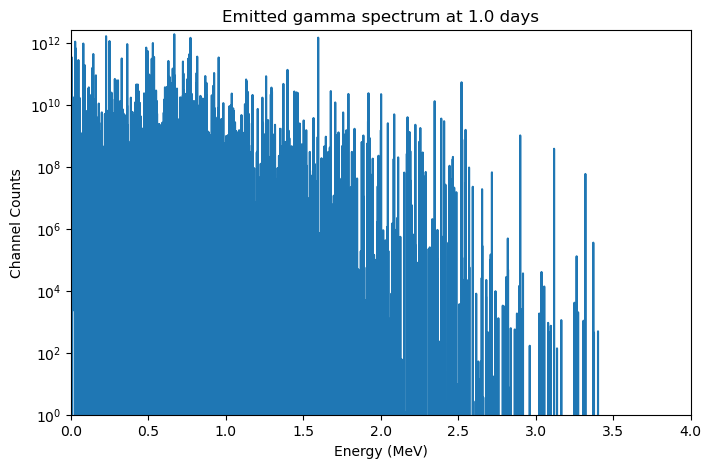

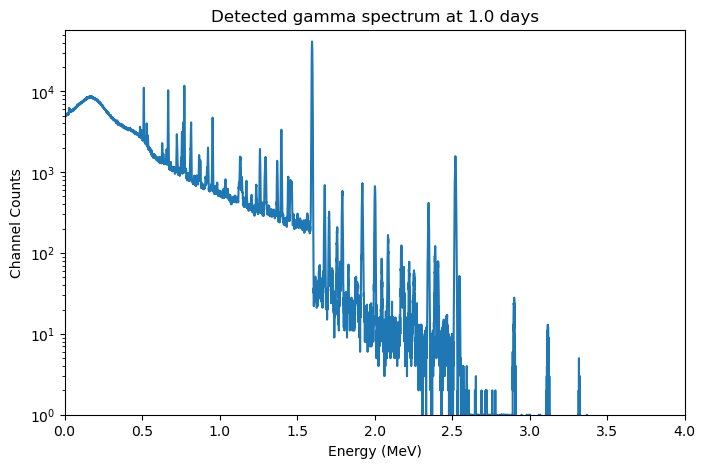

In [31]:
fig = plot.figure(figsize=(8,5))
plot.plot(detector_energy_grid[:-1], emitted_spectrum)
plot.title(f"Emitted gamma spectrum at {decay_days} days")
plot.xlabel("Energy (MeV)")
plot.ylabel("Channel Counts")
plot.yscale('log')
plot.xlim(0, 4)
plot.ylim(1,1.4*np.max(emitted_spectrum))
plot.show()

fig = plot.figure(figsize=(8,5))
plot.plot(detector_energy_grid[:-1], detected_spectrum)
plot.title(f"Detected gamma spectrum at {decay_days} days")
plot.xlabel("Energy (MeV)")
plot.ylabel("Channel Counts")
plot.yscale('log')
plot.xlim(0, 4)
plot.ylim(1,1.4*np.max(detected_spectrum))
plot.show()
